In [14]:
from google.colab import drive

# Google Drive 강제 마운트 해제
drive.flush_and_unmount()
print("✅ 기존 마운트가 성공적으로 해제되었습니다.")

✅ 기존 마운트가 성공적으로 해제되었습니다.


In [15]:
!rm -rf /content/drive/*
print("✅ /content/drive 디렉터리 내용이 모두 정리되었습니다.")

✅ /content/drive 디렉터리 내용이 모두 정리되었습니다.


In [16]:
# Drive 마운트 재시도
drive.mount('/content/drive')
print("✅ Google Drive 마운트가 완료되었습니다. 이제 다음 코드를 실행하시면 됩니다.")

Mounted at /content/drive
✅ Google Drive 마운트가 완료되었습니다. 이제 다음 코드를 실행하시면 됩니다.


In [17]:
# Colab에 Wandb를 설치 (대부분 이미 되어 있지만 확인 차원에서 실행)
!pip install wandb

# Wandb 로그인 명령어 실행
import wandb
wandb.login()

True

In [18]:
import os
import torch
import wandb
from torch import nn
import multiprocessing
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import time
import math # math.inf 사용을 위해 import

# PyTorch 데이터셋 및 데이터 로더 관련 Import
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
from torchvision import datasets, transforms
# from torchvision.transforms import transforms # 중복

# --- 환경 설정 ---
# Google Drive 경로 설정 (Colab 환경에서 마운트 후 사용)
DATA_ROOT = './data' # 로컬 데이터 저장 경로로 변경

FASHION_MNIST_LABELS = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

# --- 환경 유틸리티 함수 ---
def get_num_cpu_cores():
    """사용 가능한 CPU 코어 수 반환"""
    # 데이터 로더 num_workers를 CPU 코어 수의 절반으로 설정하는 것이 일반적
    return multiprocessing.cpu_count()

# --- 시드 설정 함수 추가 ---
def set_seed(seed=42):
    torch.manual_seed(seed) # PyTorch CPU 난수 생성기 고정
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # PyTorch GPU 난수 생성기 고정
        torch.cuda.manual_seed_all(seed)
        # 결정적 알고리즘 설정 (성능 저하 가능성 있음)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    np.random.seed(seed) # NumPy 난수 생성기 고정
    os.environ['PYTHONHASHSEED'] = str(seed) # Python 해시 시드 고정 (일부 환경 변수)

# 시드 값 설정
SEED_VALUE = 42
set_seed(SEED_VALUE)

# --- 2. 기본 설정 및 하이퍼파라미터 ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = './fashion_mnist_best_model.pth' # 로컬 경로로 변경


# --- 데이터셋 서브셋 클래스 (데이터 분할 시 유용) ---
class Subset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = list(indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

In [19]:
# --- 평균/표준편차 계산 함수 (데이터 로드 시 사용) ---
def calculate_mean_std(data_path):
    """데이터셋의 평균과 표준편차를 계산합니다."""
    # ToTensor만 적용하여 데이터셋 로드
    temp_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

    # 데이터셋의 모든 텐서를 쌓아서 평균/표준편차 계산
    imgs = torch.stack([img_t for img_t, _ in temp_dataset], dim=3)
    imgs_flat = imgs.view(1, -1)
    mean = imgs_flat.mean(dim=-1).item()
    std = imgs_flat.std(dim=-1).item()

    return mean, std

In [20]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


# --- ResNet18 for FashionMNIST ---
class ResNet18_FMNIST(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)  # dropout (optional but helpful)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [BasicBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        return self.fc(out)

In [21]:
def evaluate(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)

            # Loss 계산 추가
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0) # 배치 크기를 곱하여 정확한 총 손실 누적

            # 정확도 계산
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [22]:
def run_training():
    set_seed(SEED_VALUE)

    wandb.init(
        project="FashionMNIST-ResNet18",
        config={
            "epochs": 30,
            "batch_size": 128,
            "lr": 1e-3,
            "weight_decay": 1e-4,
            "label_smoothing": 0.1,
            "optimizer": "Adam",
            "scheduler": "CosineAnnealingLR"
        }
    )
    cfg = wandb.config

    device = DEVICE # 전역 변수 DEVICE 사용
    print(f"Device: {device}")

    # -------------------------
    # Data Normalization Constants
    f_mean_calc, f_std_calc = calculate_mean_std(DATA_ROOT)
    print(f"Calculated Mean (F_MNIST_MEAN): {f_mean_calc:.4f}")
    print(f"Calculated Std Dev (F_MNIST_STD): {f_std_calc:.4f}")

    # -------------------------
    # Data Transform with Augmentation
    # -------------------------
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(f_mean_calc, f_std_calc)
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(f_mean_calc, f_std_calc)
    ])

    # -------------------------
    # Load original datasets
    # -------------------------
    train_raw = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=True, transform=transform_train)
    test_raw  = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=True, transform=transform_test)

    # -------------------------
    # Custom Split
    # -------------------------
    # test_raw (10000개)에서 5000개는 test_dataset으로 분리
    test_dataset = Subset(test_raw, range(5000))  # 최종 테스트 5000개

    # 나머지 5000개를 train_raw(60000개)와 합쳐 총 65000개의 combined_65k 구성
    additional_5k = Subset(test_raw, range(5000, 10000))
    combined_65k = torch.utils.data.ConcatDataset([train_raw, additional_5k])

    # combined_65k (65000개)를 9:1로 분할
    train_size = int(0.9 * len(combined_65k))  # 58500
    val_size = len(combined_65k) - train_size  # 6500

    train_dataset, val_dataset = random_split(combined_65k, [train_size, val_size])

    print("--- Dataset Sizes ---")
    print(f"Train Dataset: {len(train_dataset)} samples")
    print(f"Validation Dataset: {len(val_dataset)} samples")
    print(f"Test Dataset: {len(test_dataset)} samples")
    print("---------------------")

    # -------------------------
    # DataLoaders
    # -------------------------
    # num_workers는 CPU 코어 수를 고려하여 설정
    num_workers = min(get_num_cpu_cores() // 2, 4) if get_num_cpu_cores() > 1 else 0

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    # -------------------------
    # Model, Loss, Optimizer
    # -------------------------
    model = ResNet18_FMNIST().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

    EPOCHS = cfg.epochs
    best_val_acc = 0
    save_path = CHECKPOINT_PATH # 전역 변수 CHECKPOINT_PATH 사용

    # -------------------------
    # Training Loop
    # -------------------------
    print("\n--- Starting Training ---")
    total_start = time.time()

    for epoch in range(1, EPOCHS + 1): # 1부터 시작하도록 수정

        epoch_start = time.time()
        model.train()
        total_train_loss = 0

        # tqdm을 사용하여 훈련 과정 시각화
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} (Train)", leave=False)

        for x, y in pbar:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * y.size(0) # 배치 크기를 곱하여 정확한 총 손실 누적

        scheduler.step()

        # 훈련 손실 계산 (평균)
        train_loss = total_train_loss / len(train_dataset)

        # 훈련/검증 평가
        # evaluate 함수는 (avg_loss, accuracy)를 반환
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        _, train_acc = evaluate(model, train_loader, criterion, device) # 훈련 정확도는 손실 계산 없이 진행 (첫 번째 반환값 무시)

        epoch_time = time.time() - epoch_start

        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            if cfg.optimizer == "Adam":
                print(f"  [Checkpoint] Val Acc improved! Saving model to {save_path}")


        # -------------------------
        # Wandb Logging & Console Print
        # -------------------------
        wandb.log({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": optimizer.param_groups[0]["lr"],
            "epoch": epoch
        })

        print(
            f"Epoch [{epoch}/{EPOCHS}] | "
            f"Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% (Train) | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% (Val) | "
            f"Time: {epoch_time:.2f} sec"
        )

    print("\n--- Training Finished ---")

    # -------------------------
    # Final Test Accuracy
    # -------------------------
    print("\n--- Evaluating Final Test Set ---")

    # 최고 성능 모델 로드
    model.load_state_dict(torch.load(save_path))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    total_time = time.time() - total_start

    print(f"\n[FINAL RESULT]")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Total Training Time: {total_time:.2f} seconds")

    wandb.log({"test_loss": test_loss, "test_acc": test_acc})
    wandb.finish()

    return f_mean_calc, f_std_calc



In [23]:
def get_analysis_test_loader(data_path, mean, std):
    """분석을 위한 테스트 데이터셋 로드 함수"""
    # 정규화는 튜플 형식으로 전달
    mean_tuple = (mean,)
    std_tuple = (std,)

    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_tuple, std=std_tuple)
    ])

    test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=test_transforms)

    # 전체 배치를 한 번에 로드하는 DataLoader
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)
    return test_loader


def analyze_sample_predictions(mean_val, std_val, num_samples=10):
    """훈련된 모델을 로드하여 임의 샘플에 대한 예측 결과를 시각화하고 오분류를 분석합니다."""

    # 1. 테스트 데이터 로드
    test_loader = get_analysis_test_loader(DATA_ROOT, mean_val, std_val)

    # 2. 모델 객체 초기화 (ResNet18_FMNIST)
    final_model = ResNet18_FMNIST()

    print(f"\n{'='*10} 임의 샘플 {num_samples}개 분류 예측 확인 및 오분류 분석 {'='*10}")

    # 모델 로드
    if CHECKPOINT_PATH and os.path.exists(CHECKPOINT_PATH):
        try:
            final_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
            print(f"모델 체크포인트 로드 완료: {CHECKPOINT_PATH}")
        except Exception as e:
            print(f"[치명적 오류] 모델 가중치 로드 실패: {e}")
            print("모델 구조 불일치 또는 파일 손상. 초기화된 모델을 사용합니다.")

    else:
        print(f"체크포인트 파일이 존재하지 않습니다: {CHECKPOINT_PATH}")
        print("훈련된 모델 가중치를 로드할 수 없어 초기화된 모델을 사용합니다.")


    final_model.eval()
    final_model.to(DEVICE)

    # 1. 테스트 데이터 전체 가져오기
    try:
        inputs, labels = next(iter(test_loader))
    except StopIteration:
        print("테스트 로더에 데이터가 없습니다.")
        return

    # 2. 10개의 임의 인덱스 선택
    total_indices = np.arange(len(labels))
    selected_indices = np.random.choice(total_indices, size=num_samples, replace=False)

    sample_inputs = inputs[selected_indices].to(DEVICE)
    sample_labels = labels[selected_indices].to(DEVICE)

    incorrect_predictions = []

    # 3. 예측 수행 및 시각화
    with torch.no_grad():
        outputs = final_model(sample_inputs)
        _, preds = torch.max(outputs, 1)

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()

        for i in range(num_samples):
            pred_label = FASHION_MNIST_LABELS[preds[i].item()]
            true_label = FASHION_MNIST_LABELS[sample_labels[i].item()]
            is_correct = (preds[i] == sample_labels[i]).item()

            # 이미지 시각화를 위해 정규화 역변환
            img_tensor = sample_inputs[i].cpu().squeeze()
            img = img_tensor * std_val + mean_val # 계산된 단일 값으로 역정규화
            img = img.numpy()
            img = np.clip(img, 0, 1) # 클리핑

            ax = axes[i]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {true_label}\nPred: {pred_label}",
                          color='green' if is_correct else 'red',
                          fontsize=10)
            ax.axis('off')

            # 4. 오분류 사례 기록
            if not is_correct:
                model_confidences = F.softmax(outputs[i], dim=0).cpu().numpy()
                top_3_indices = np.argsort(model_confidences)[::-1][:3]
                top_3_confidences = [(FASHION_MNIST_LABELS[idx], model_confidences[idx]) for idx in top_3_indices]

                incorrect_predictions.append({
                    'index_in_batch': selected_indices[i].item(),
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'top_3_confidences': top_3_confidences
                })

        plt.tight_layout()
        plt.show()

    print("\n" + "="*50)
    print(f"요약: 총 {num_samples}개 샘플 중 {len(incorrect_predictions)}개 오분류 발생")
    print("="*50)

    # 5. 오분류 해석 요청 출력 (정보 강화)
    if incorrect_predictions:
        print("오분류 사례 분석:")
        for k, item in enumerate(incorrect_predictions):
            print(f"\n[오분류 {k+1}] (원본 테스트셋 인덱스: {item['index_in_batch']})")
            print(f"  - 실제 레이블: {item['true_label']}")
            print(f"  - 모델 예측: {item['predicted_label']} (틀림)")
            print("  - 모델의 Top 3 확신도:")
            for label, conf in item['top_3_confidences']:
                print(f"    - {label}: {conf:.4f}")
            print(f"  - **해석 작성 필요:** 이 이미지를 보고 분류 결과가 틀린 이유를 분석하세요.")
    else:
        print("모든 샘플이 정확하게 분류되었습니다.")

Device: cuda:0
Calculated Mean (F_MNIST_MEAN): 0.2860
Calculated Std Dev (F_MNIST_STD): 0.3530
--- Dataset Sizes ---
Train Dataset: 58500 samples
Validation Dataset: 6500 samples
Test Dataset: 5000 samples
---------------------

--- Starting Training ---


Epoch 1/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [1/30] | Loss: 0.9541 | Acc: 86.08% (Train) | Val Loss: 0.8214 | Val Acc: 86.15% (Val) | Time: 70.29 sec


Epoch 2/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [2/30] | Loss: 0.7846 | Acc: 87.72% (Train) | Val Loss: 0.7656 | Val Acc: 87.92% (Val) | Time: 69.62 sec


Epoch 3/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [3/30] | Loss: 0.7423 | Acc: 83.77% (Train) | Val Loss: 0.8776 | Val Acc: 83.05% (Val) | Time: 69.61 sec


Epoch 4/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [4/30] | Loss: 0.7345 | Acc: 88.01% (Train) | Val Loss: 0.7726 | Val Acc: 88.18% (Val) | Time: 69.83 sec


Epoch 5/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [5/30] | Loss: 0.7167 | Acc: 90.99% (Train) | Val Loss: 0.7080 | Val Acc: 90.77% (Val) | Time: 69.70 sec


Epoch 6/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [6/30] | Loss: 0.7059 | Acc: 90.54% (Train) | Val Loss: 0.7269 | Val Acc: 90.66% (Val) | Time: 69.40 sec


Epoch 7/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [7/30] | Loss: 0.7002 | Acc: 91.69% (Train) | Val Loss: 0.6880 | Val Acc: 91.77% (Val) | Time: 68.45 sec


Epoch 8/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [8/30] | Loss: 0.6883 | Acc: 92.19% (Train) | Val Loss: 0.6911 | Val Acc: 91.58% (Val) | Time: 68.41 sec


Epoch 9/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [9/30] | Loss: 0.6809 | Acc: 92.96% (Train) | Val Loss: 0.6714 | Val Acc: 92.32% (Val) | Time: 69.03 sec


Epoch 10/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [10/30] | Loss: 0.6772 | Acc: 92.07% (Train) | Val Loss: 0.6886 | Val Acc: 92.18% (Val) | Time: 69.39 sec


Epoch 11/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [11/30] | Loss: 0.6664 | Acc: 91.65% (Train) | Val Loss: 0.6961 | Val Acc: 91.08% (Val) | Time: 69.21 sec


Epoch 12/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [12/30] | Loss: 0.6589 | Acc: 91.88% (Train) | Val Loss: 0.7022 | Val Acc: 91.40% (Val) | Time: 69.32 sec


Epoch 13/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [13/30] | Loss: 0.6565 | Acc: 93.77% (Train) | Val Loss: 0.6644 | Val Acc: 92.72% (Val) | Time: 69.50 sec


Epoch 14/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [14/30] | Loss: 0.6458 | Acc: 92.25% (Train) | Val Loss: 0.6877 | Val Acc: 91.46% (Val) | Time: 69.13 sec


Epoch 15/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [15/30] | Loss: 0.6425 | Acc: 94.11% (Train) | Val Loss: 0.6519 | Val Acc: 93.54% (Val) | Time: 69.44 sec


Epoch 16/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [16/30] | Loss: 0.6323 | Acc: 94.59% (Train) | Val Loss: 0.6436 | Val Acc: 93.92% (Val) | Time: 68.94 sec


Epoch 17/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [17/30] | Loss: 0.6227 | Acc: 94.91% (Train) | Val Loss: 0.6383 | Val Acc: 93.85% (Val) | Time: 68.58 sec


Epoch 18/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [18/30] | Loss: 0.6174 | Acc: 94.79% (Train) | Val Loss: 0.6456 | Val Acc: 93.69% (Val) | Time: 69.09 sec


Epoch 19/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [19/30] | Loss: 0.6135 | Acc: 95.78% (Train) | Val Loss: 0.6310 | Val Acc: 94.29% (Val) | Time: 69.33 sec


Epoch 20/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [20/30] | Loss: 0.6023 | Acc: 96.17% (Train) | Val Loss: 0.6255 | Val Acc: 94.37% (Val) | Time: 69.50 sec


Epoch 21/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [21/30] | Loss: 0.5954 | Acc: 96.43% (Train) | Val Loss: 0.6252 | Val Acc: 94.34% (Val) | Time: 69.42 sec


Epoch 22/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [22/30] | Loss: 0.5892 | Acc: 96.97% (Train) | Val Loss: 0.6166 | Val Acc: 94.83% (Val) | Time: 69.68 sec


Epoch 23/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [23/30] | Loss: 0.5837 | Acc: 96.98% (Train) | Val Loss: 0.6209 | Val Acc: 94.88% (Val) | Time: 69.14 sec


Epoch 24/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [24/30] | Loss: 0.5762 | Acc: 97.33% (Train) | Val Loss: 0.6186 | Val Acc: 95.05% (Val) | Time: 69.21 sec


Epoch 25/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [25/30] | Loss: 0.5697 | Acc: 97.54% (Train) | Val Loss: 0.6147 | Val Acc: 95.05% (Val) | Time: 68.23 sec


Epoch 26/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [26/30] | Loss: 0.5649 | Acc: 97.69% (Train) | Val Loss: 0.6185 | Val Acc: 95.14% (Val) | Time: 69.02 sec


Epoch 27/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [27/30] | Loss: 0.5601 | Acc: 97.97% (Train) | Val Loss: 0.6124 | Val Acc: 95.09% (Val) | Time: 69.62 sec


Epoch 28/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [28/30] | Loss: 0.5575 | Acc: 98.06% (Train) | Val Loss: 0.6122 | Val Acc: 95.31% (Val) | Time: 68.99 sec


Epoch 29/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [29/30] | Loss: 0.5548 | Acc: 98.10% (Train) | Val Loss: 0.6111 | Val Acc: 95.29% (Val) | Time: 68.96 sec


Epoch 30/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [30/30] | Loss: 0.5540 | Acc: 98.10% (Train) | Val Loss: 0.6128 | Val Acc: 94.95% (Val) | Time: 69.12 sec

--- Training Finished ---

--- Evaluating Final Test Set ---

[FINAL RESULT]
Test Loss: 0.6230
Test Accuracy: 94.84%
Total Training Time: 2080.17 seconds


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▂▃▁▃▅▄▅▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇███████
train_loss,█▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▃▄▁▄▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█████████
val_loss,▇▅█▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,30
lr,0
test_acc,0.9484


Device: cuda:0
Calculated Mean (F_MNIST_MEAN): 0.2860
Calculated Std Dev (F_MNIST_STD): 0.3530
--- Dataset Sizes ---
Train Dataset: 58500 samples
Validation Dataset: 6500 samples
Test Dataset: 5000 samples
---------------------

--- Starting Training ---


Epoch 1/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [1/30] | Loss: 0.9541 | Acc: 86.08% (Train) | Val Loss: 0.8214 | Val Acc: 86.15% (Val) | Time: 69.09 sec


Epoch 2/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [2/30] | Loss: 0.7846 | Acc: 87.72% (Train) | Val Loss: 0.7656 | Val Acc: 87.92% (Val) | Time: 68.78 sec


Epoch 3/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [3/30] | Loss: 0.7423 | Acc: 83.77% (Train) | Val Loss: 0.8776 | Val Acc: 83.05% (Val) | Time: 69.16 sec


Epoch 4/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [4/30] | Loss: 0.7345 | Acc: 88.01% (Train) | Val Loss: 0.7726 | Val Acc: 88.18% (Val) | Time: 69.24 sec


Epoch 5/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [5/30] | Loss: 0.7167 | Acc: 90.99% (Train) | Val Loss: 0.7080 | Val Acc: 90.77% (Val) | Time: 69.43 sec


Epoch 6/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [6/30] | Loss: 0.7059 | Acc: 90.54% (Train) | Val Loss: 0.7269 | Val Acc: 90.66% (Val) | Time: 69.34 sec


Epoch 7/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [7/30] | Loss: 0.7002 | Acc: 91.69% (Train) | Val Loss: 0.6880 | Val Acc: 91.77% (Val) | Time: 69.31 sec


Epoch 8/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [8/30] | Loss: 0.6883 | Acc: 92.19% (Train) | Val Loss: 0.6911 | Val Acc: 91.58% (Val) | Time: 69.32 sec


Epoch 9/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [9/30] | Loss: 0.6809 | Acc: 92.96% (Train) | Val Loss: 0.6714 | Val Acc: 92.32% (Val) | Time: 68.70 sec


Epoch 10/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [10/30] | Loss: 0.6772 | Acc: 92.07% (Train) | Val Loss: 0.6886 | Val Acc: 92.18% (Val) | Time: 69.07 sec


Epoch 11/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [11/30] | Loss: 0.6664 | Acc: 91.65% (Train) | Val Loss: 0.6961 | Val Acc: 91.08% (Val) | Time: 69.47 sec


Epoch 12/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [12/30] | Loss: 0.6589 | Acc: 91.88% (Train) | Val Loss: 0.7022 | Val Acc: 91.40% (Val) | Time: 69.63 sec


Epoch 13/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [13/30] | Loss: 0.6565 | Acc: 93.77% (Train) | Val Loss: 0.6644 | Val Acc: 92.72% (Val) | Time: 69.42 sec


Epoch 14/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [14/30] | Loss: 0.6458 | Acc: 92.25% (Train) | Val Loss: 0.6877 | Val Acc: 91.46% (Val) | Time: 69.09 sec


Epoch 15/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [15/30] | Loss: 0.6425 | Acc: 94.11% (Train) | Val Loss: 0.6519 | Val Acc: 93.54% (Val) | Time: 69.09 sec


Epoch 16/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [16/30] | Loss: 0.6323 | Acc: 94.59% (Train) | Val Loss: 0.6436 | Val Acc: 93.92% (Val) | Time: 68.93 sec


Epoch 17/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [17/30] | Loss: 0.6227 | Acc: 94.91% (Train) | Val Loss: 0.6383 | Val Acc: 93.85% (Val) | Time: 68.44 sec


Epoch 18/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [18/30] | Loss: 0.6174 | Acc: 94.79% (Train) | Val Loss: 0.6456 | Val Acc: 93.69% (Val) | Time: 68.93 sec


Epoch 19/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [19/30] | Loss: 0.6135 | Acc: 95.78% (Train) | Val Loss: 0.6310 | Val Acc: 94.29% (Val) | Time: 69.08 sec


Epoch 20/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [20/30] | Loss: 0.6023 | Acc: 96.17% (Train) | Val Loss: 0.6255 | Val Acc: 94.37% (Val) | Time: 68.77 sec


Epoch 21/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [21/30] | Loss: 0.5954 | Acc: 96.43% (Train) | Val Loss: 0.6252 | Val Acc: 94.34% (Val) | Time: 68.80 sec


Epoch 22/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [22/30] | Loss: 0.5892 | Acc: 96.97% (Train) | Val Loss: 0.6166 | Val Acc: 94.83% (Val) | Time: 68.90 sec


Epoch 23/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [23/30] | Loss: 0.5837 | Acc: 96.98% (Train) | Val Loss: 0.6209 | Val Acc: 94.88% (Val) | Time: 68.05 sec


Epoch 24/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [24/30] | Loss: 0.5762 | Acc: 97.33% (Train) | Val Loss: 0.6186 | Val Acc: 95.05% (Val) | Time: 68.30 sec


Epoch 25/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [25/30] | Loss: 0.5697 | Acc: 97.54% (Train) | Val Loss: 0.6147 | Val Acc: 95.05% (Val) | Time: 68.90 sec


Epoch 26/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [26/30] | Loss: 0.5649 | Acc: 97.69% (Train) | Val Loss: 0.6185 | Val Acc: 95.14% (Val) | Time: 72.11 sec


Epoch 27/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [27/30] | Loss: 0.5601 | Acc: 97.97% (Train) | Val Loss: 0.6124 | Val Acc: 95.09% (Val) | Time: 68.70 sec


Epoch 28/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

  [Checkpoint] Val Acc improved! Saving model to ./fashion_mnist_best_model.pth
Epoch [28/30] | Loss: 0.5575 | Acc: 98.06% (Train) | Val Loss: 0.6122 | Val Acc: 95.31% (Val) | Time: 69.01 sec


Epoch 29/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [29/30] | Loss: 0.5548 | Acc: 98.10% (Train) | Val Loss: 0.6111 | Val Acc: 95.29% (Val) | Time: 68.68 sec


Epoch 30/30 (Train):   0%|          | 0/458 [00:00<?, ?it/s]

Epoch [30/30] | Loss: 0.5540 | Acc: 98.10% (Train) | Val Loss: 0.6128 | Val Acc: 94.95% (Val) | Time: 68.02 sec

--- Training Finished ---

--- Evaluating Final Test Set ---

[FINAL RESULT]
Test Loss: 0.6230
Test Accuracy: 94.84%
Total Training Time: 2075.21 seconds


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▂▃▁▃▅▄▅▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇███████
train_loss,█▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▃▄▁▄▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█████████
val_loss,▇▅█▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,30
lr,0
test_acc,0.9484



========== 임의 샘플 10개 분류 예측 확인 및 오분류 분석 ==========
모델 체크포인트 로드 완료: ./fashion_mnist_best_model.pth


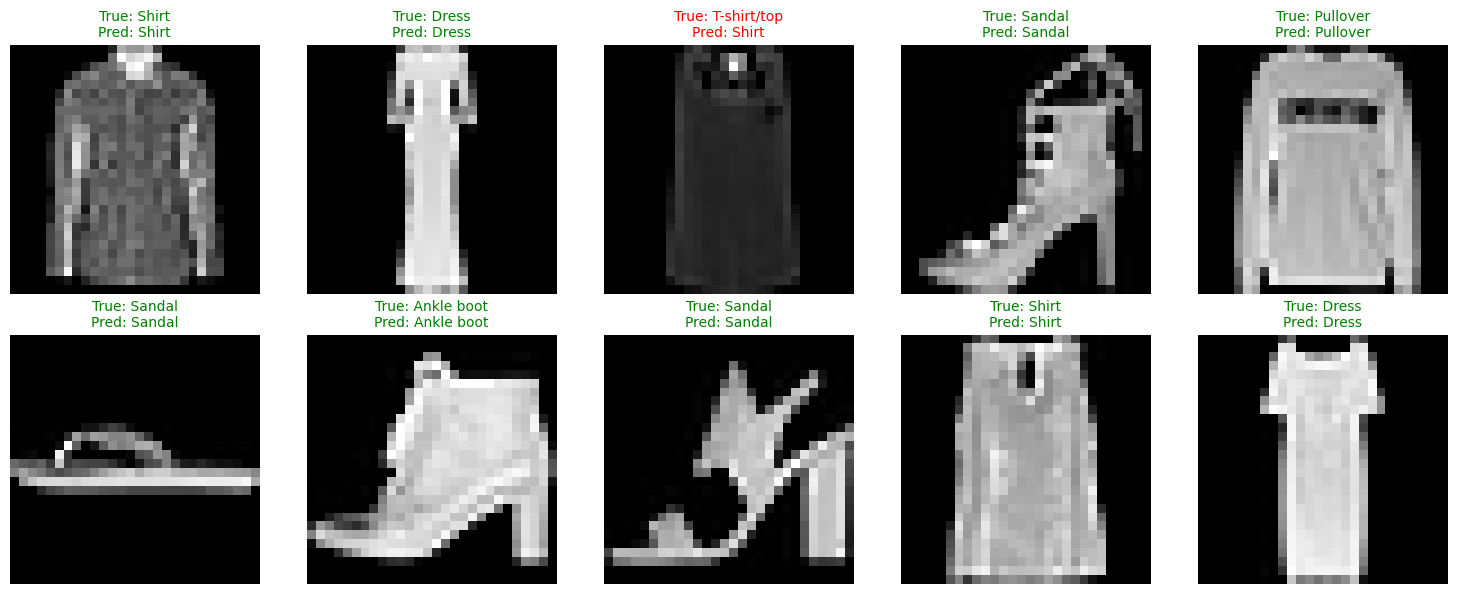


요약: 총 10개 샘플 중 1개 오분류 발생
오분류 사례 분석:

[오분류 1] (원본 테스트셋 인덱스: 1731)
  - 실제 레이블: T-shirt/top
  - 모델 예측: Shirt (틀림)
  - 모델의 Top 3 확신도:
    - Shirt: 0.4593
    - T-shirt/top: 0.4384
    - Pullover: 0.0170
  - **해석 작성 필요:** 이 이미지를 보고 분류 결과가 틀린 이유를 분석하세요.


In [24]:
if __name__ == '__main__':

    # 훈련 (Mean/Std Dev 계산)
    run_training()

    # run_training()의 반환값(계산된 mean, std)을 받기 위해 변수 정의
    calculated_mean, calculated_std = run_training()

    # 분석 실행 (저장된 체크포인트 파일이 존재해야 합니다)
    analyze_sample_predictions(calculated_mean, calculated_std)

고찰

ResNet이라는 유명한 이미지 모델을 이용하여 이미지 인식 모델을 만들었습니다.
처음에는 CNN구조를 직접 구조화하여 모델을 구상하였지만, val_acc : 93%, test_acc : 91% 정도로 생각보다 정확도가 높지 않아서 ResNet을 이용하였습니다.
데이터 증강도 가우시안 노이즈와 밝기 조절로 해보았지만, 유의미한 결과를 얻지 못하여 증강을 사용하지 않고 구성해보았습니다.
이번 과제로 약 50번 정도 모델 훈련을 하면서 데이터의 종류를 먼저 보고 데이터
증강의 종류를 선택해야 하며, 과적합을 해결하는 방법(규제 강화, 복잡한 모델의 간략화)등 많은 시행착오를 겪으며, 많은 공부를 해서 뜻깊은 시간이었습니다.